# ROOF IMÓVEIS

## ANÁLISE DE DADOS PARA RECOMENDAÇÃO DE INVESTIMENTOS EM IMÓVEIS

#### Aluno: Luiz Paulo Zamprogno
#### RID: 32705
---



In [1]:
!pip install uszipcode
!pip install geopandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 120 kB 7.3 MB/s 
     |████████████████████████████████| 76 kB 5.5 MB/s 
     |████████████████████████████████| 45 kB 3.3 MB/s 
     |████████████████████████████████| 41 kB 436 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 2.7 MB/s 
     |████████████████████████████████| 6.3 MB 39.4 MB/s 
     |████████████████████████████████| 16.7 MB 379 kB/s 


In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
from shapely.geometry import Point, Polygon

/usr/local/lib/python3.7/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# 1 - CARREGAMENTO DOS DADOS
## 1.1 - Primeiro vamos ler o arquivo .csv contendo os dados

In [3]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Min projeto/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


# 2 - LIMPEZA DOS DADOS
## 2.1 - Precisamos verificar os tipos de dados de todas as colunas.
#### Podemos notar que os campos 'date', 'price', 'bathrooms', 'floors' estão com tipos de dados incoerentes. Vamos analisar um de cada vez.

In [4]:
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

## 2.2 - Coluna DATE
### Vamos transformar a coluna 'date' para o tipo datetime, para facilitar algum calculo no futuro.

In [5]:
df['date'] = pd.to_datetime(df['date'])
df.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 2.3 - Coluna PRICE
### Vamos transformar a coluna 'price' para inteiro, pois o valor decimal em centavos não afetará significativamente a nossa análise

In [6]:
df['price'] = df['price'].astype(int)
df.dtypes

id                        int64
date             datetime64[ns]
price                     int64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 2.4 - Coluna BATHROOMS
### Se analisarmos o campo 'bathrooms', percebemos que temos uma quantidade considerável de dados indicando que existem casas com quantidade de banheiros como número fracionário e zerados. E não existem casas com, por exemplo, dois banheiros e meio. A quantidade de banheiros em uma casa é um fator muito relevante no momento da compra, portanto deve haver um erro na base de dados e deve ser verificado com a fonte. Mas para continuar nossa análise vamos considerar o arredondadmento do valor para baixo

In [7]:
# verificar
df['bathrooms'].value_counts()

2.50    5380
1.00    3852
1.75    3048
2.25    2047
2.00    1930
1.50    1446
2.75    1185
3.00     753
3.50     731
3.25     589
3.75     155
4.00     136
4.50     100
4.25      79
0.75      72
4.75      23
5.00      21
5.25      13
0.00      10
5.50      10
1.25       9
6.00       6
0.50       4
5.75       4
6.75       2
8.00       2
6.25       2
6.50       2
7.50       1
7.75       1
Name: bathrooms, dtype: int64

In [8]:
# arredondar a quantidade de banheiros para baixo
df['bathrooms'].apply(np.floor)
df['bathrooms'] = df['bathrooms'].astype(int)

In [9]:
# excluir os banheiros com valor zero
df.drop(df[df['bathrooms'] == 0].index, inplace=True)

In [10]:
# verificar se tudo está certo
df['bathrooms'].value_counts()

2    10542
1     8355
3     2228
4      338
5       48
6       12
8        2
7        2
Name: bathrooms, dtype: int64

## 2.5 - Coluna BEDROOMS
### Na coluna 'bedrooms', vemos que 5 casas tem quantidade de quartos igual a zero, vamos encontrá-lo e excluí-los

In [11]:
# verificar
df['bedrooms'].value_counts()

3     9808
4     6879
2     2732
5     1601
6      272
1      168
7       38
8       13
9        6
0        5
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [12]:
# excluir os quartos com valor zero
df.drop(df[df['bedrooms'] == 0].index, inplace=True)

In [13]:
# verificar
df['bedrooms'].value_counts()

3     9808
4     6879
2     2732
5     1601
6      272
1      168
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

## 2.6 - Coluna FLOORS
### Com a mesma lógica utilizada para a coluna banheiros, considerei um erro para casas com pisos fracionários, então também arredondei para baixo. 

In [14]:
df['floors'].value_counts()

1.0    10607
2.0     8231
1.5     1905
3.0      611
2.5      161
3.5        7
Name: floors, dtype: int64

In [15]:
# arredondar a quantidade de pisos para baixo
df['floors'].apply(np.floor)
df['floors'] = df['floors'].astype(int)

In [16]:
df['floors'].value_counts()

1    12512
2     8392
3      618
Name: floors, dtype: int64

## 2.7 - Checar se existem algum campo zerado em todo o dataframe

In [17]:
df.isnull().values.any()

False

# 3 - VERIFICAÇÃO DE OUTLIERS

In [18]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900,3,1,1180,5650,1,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,2014-12-09,538000,3,2,2570,7242,2,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2015-02-25,180000,2,1,770,10000,1,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,2014-12-09,604000,4,3,1960,5000,1,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2015-02-18,510000,3,2,1680,8080,1,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


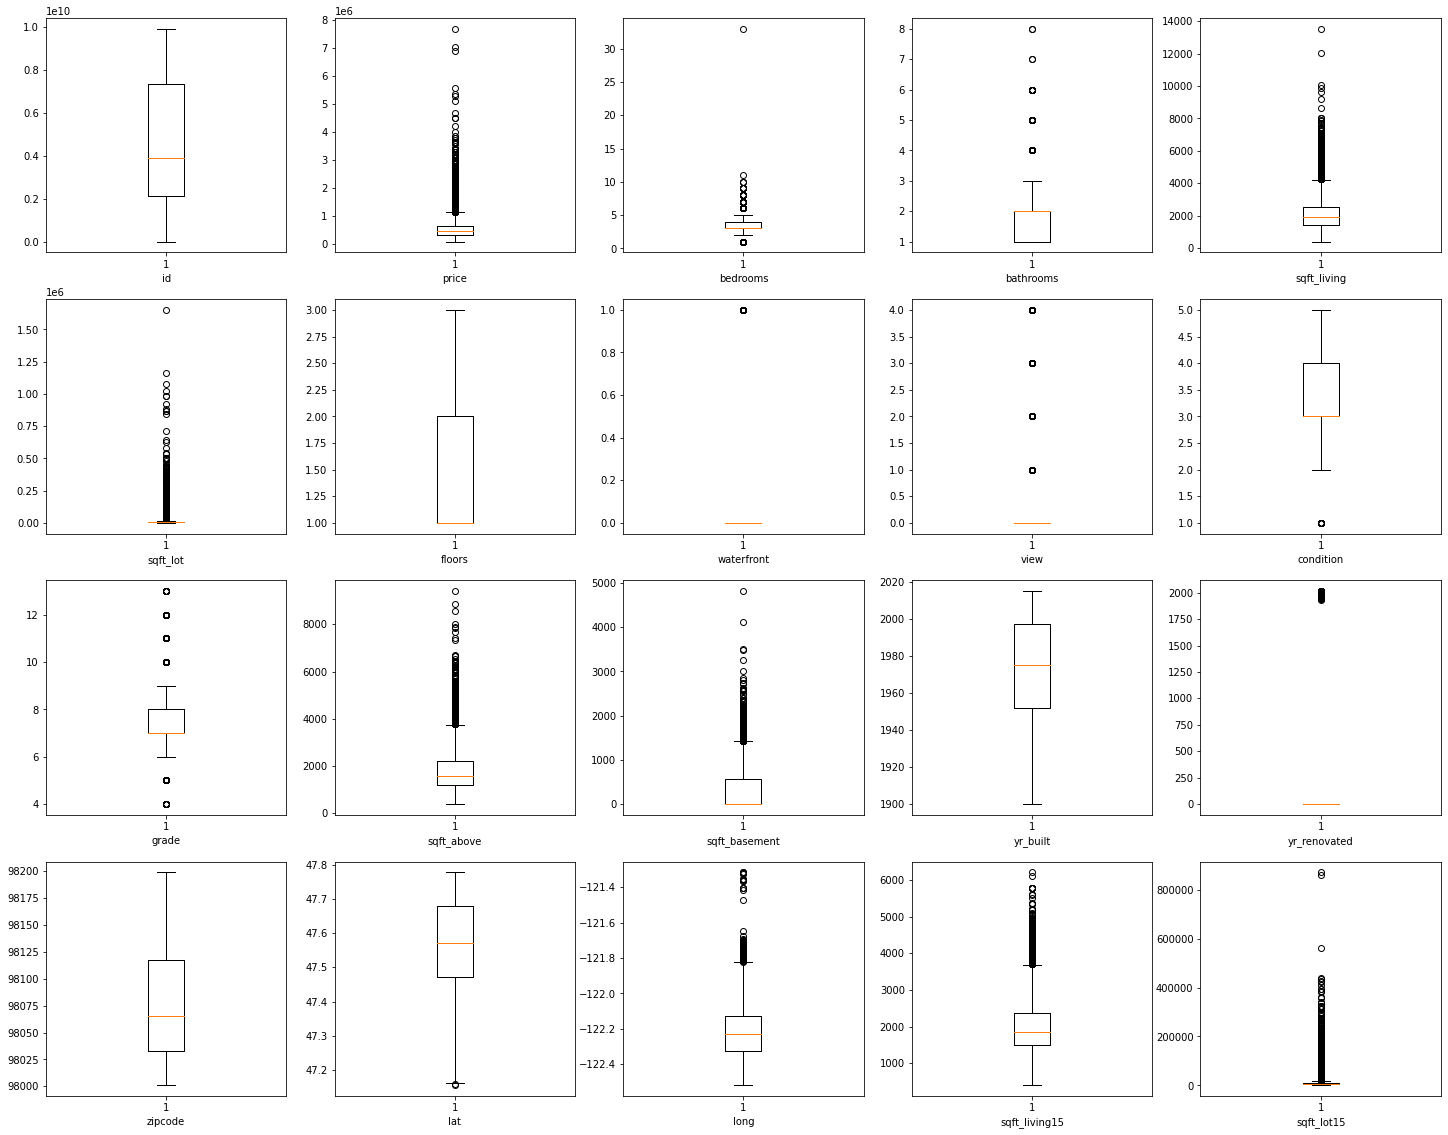

In [19]:
fig = plt.figure(figsize=(25, 25))

z = 1

# plotar um gráfico de boxplot para cada coluna, menos a coluna 'date'
for each in df.columns:
  if not each == 'date':
    ax = fig.add_subplot(5, 5, z)
    ax.set_xlabel(each)
    ax.boxplot(data=df, x=each);
    z += 1

## 3.1 - Os gráficos de boxplot nos auxiliam na visualização de outliers. Todos parecem estar coerentes, exceto a coluna 'bedrooms', então vamos analisar ela mais uma vez.

In [20]:
df['bedrooms'].value_counts().sort_values()

11       1
33       1
10       3
9        6
8       13
7       38
1      168
6      272
5     1601
2     2732
4     6879
3     9808
Name: bedrooms, dtype: int64

## 3.2 - Vamos analisar as outras colunas das casas que tem 10, 11, e 33 quartos

In [21]:
df.loc[(df['bedrooms'] == 10) | (df['bedrooms'] == 11) | (df['bedrooms'] == 33)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8757,1773100755,2014-08-21,520000,11,3,3000,4960,2,0,0,...,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
13314,627300145,2014-08-14,1148000,10,5,4590,10920,1,0,2,...,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
15161,5566100170,2014-10-29,650000,10,2,3610,11914,2,0,0,...,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914
15870,2402100895,2014-06-25,640000,33,1,1620,6000,1,0,0,...,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700
19254,8812401450,2014-12-29,660000,10,3,2920,3745,2,0,0,...,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745


## 3.3 - Uma casa de 33 quartos, 1 banheiro, 1 piso e com uma área de construção tão pequena para tal, é um pouco estranho, então excluí essa linha do dataframe

In [22]:
# excluir o quarto com valor 33
df.drop(df[df['bedrooms'] == 33].index, inplace=True)

In [23]:
# verificar
df['bedrooms'].value_counts().sort_values()

11       1
10       3
9        6
8       13
7       38
1      168
6      272
5     1601
2     2732
4     6879
3     9808
Name: bedrooms, dtype: int64

# 4 - ANÁLISE DE DADOS
## 4.1 - Vamos buscar o nome da cidade e a população de acordo com cada 'zipcode'

In [24]:
# uso da biblioteca uszipcode para buscar o nome da cidade e população de cada zip code
engine = SearchEngine()

cities = []
population = []

for city in df['zipcode']:
  zipcode = engine.by_zipcode(city)
  cities.append(zipcode.major_city)
  population.append(zipcode.population)

df['city'] = cities
df['population'] = population

Download /root/.uszipcode/simple_db.sqlite from https://github.com/MacHu-GWU/uszipcode-project/releases/download/1.0.1.db/simple_db.sqlite ...
  1.00 MB downloaded ...
  2.00 MB downloaded ...
  3.00 MB downloaded ...
  4.00 MB downloaded ...
  5.00 MB downloaded ...
  6.00 MB downloaded ...
  7.00 MB downloaded ...
  8.00 MB downloaded ...
  9.00 MB downloaded ...
  10.00 MB downloaded ...
  11.00 MB downloaded ...
  Complete!


In [25]:
# calculando o preço por área construída
df['price_sqft'] = (df['price'] / df['sqft_lot']).astype(float)
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,city,population,price_sqft
0,7129300520,2014-10-13,221900,3,1,1180,5650,1,0,0,...,1955,0,98178,47.5112,-122.257,1340,5650,Seattle,24092,39.274336
1,6414100192,2014-12-09,538000,3,2,2570,7242,2,0,0,...,1951,1991,98125,47.7210,-122.319,1690,7639,Seattle,37081,74.288870
2,5631500400,2015-02-25,180000,2,1,770,10000,1,0,0,...,1933,0,98028,47.7379,-122.233,2720,8062,Kenmore,20419,18.000000
3,2487200875,2014-12-09,604000,4,3,1960,5000,1,0,0,...,1965,0,98136,47.5208,-122.393,1360,5000,Seattle,14770,120.800000
4,1954400510,2015-02-18,510000,3,2,1680,8080,1,0,0,...,1987,0,98074,47.6168,-122.045,1800,7503,Sammamish,25748,63.118812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21606,7936000429,2015-03-26,1007500,4,3,3510,7200,2,0,0,...,2009,0,98136,47.5537,-122.398,2050,6200,Seattle,14770,139.930556
21607,2997800021,2015-02-19,475000,3,2,1310,1294,2,0,0,...,2008,0,98116,47.5773,-122.409,1330,1265,Seattle,22241,367.078825
21608,263000018,2014-05-21,360000,3,2,1530,1131,3,0,0,...,2009,0,98103,47.6993,-122.346,1530,1509,Seattle,45911,318.302387
21609,6600060120,2015-02-23,400000,4,2,2310,5813,2,0,0,...,2014,0,98146,47.5107,-122.362,1830,7200,Seattle,25922,68.811285


## 4.2 - Criar uma coluna com a idade da residência
#### considerando as residências com 0 anos, vendidas no mesmo ano da construção, e as 12 residências com -1 anos, considerando que foram vendidas antes do término da construção

In [26]:
# calcular a idade de cada casa em anos em relação a ultima venda
df['age'] = df.date.dt.year - df['yr_built']
df['age'].value_counts()

 9      472
 8      443
 11     431
 0      430
 10     428
       ... 
 113     28
 115     26
 81      22
 80      21
-1       12
Name: age, Length: 117, dtype: int64

## 4.3 - Também vou checar quantos anos após a reforma, se existir

In [27]:
# criar a coluna 'yr_renovated' para saber quantos anos a residência tem depois da reforma
df.loc[df['yr_renovated'] == 0, 'age_renovated'] = 0
df.loc[df['yr_renovated'] != 0, 'age_renovated'] = df.date.dt.year - df['yr_renovated']
df['age_renovated']

0         0.0
1        23.0
2         0.0
3         0.0
4         0.0
         ... 
21606     0.0
21607     0.0
21608     0.0
21609     0.0
21611     0.0
Name: age_renovated, Length: 21521, dtype: float64

## 4.4 - Agrupar os dados por 'id' para saber se houve mais de uma ocorrência de venda no período, e calcular a diferença para saber se a casa valorizou ou não.

In [28]:
df2 = df.groupby('id')['price'].agg(['min', 'max'])

# criar a coluna 'appreciation' para verificar se alguma casa teve valorização na venda ou não
df2.loc[(df2['max'] > df2['min']), 'appreciation'] = 'Valorizou'
df2.loc[(df2['min'] > df2['max']), 'appreciation'] = 'Desvalorizou'
df2.loc[(df2['max'] == df2['min']), 'appreciation'] = 'Sem venda'

## 4.5 - Assim podemos ver que 172 tiveram mais de uma venda, e valorizaram no negócio, e o restante teve somente uma ocorrência de venda.

In [29]:
# verificar
df2['appreciation'].value_counts()

Sem venda    21173
Valorizou      172
Name: appreciation, dtype: int64

In [84]:
# criar a coluna 'difference' para saber o quanto valorizou
df2['difference'] = df2['max'] - df2['min']
df2

,min,max,appreciation,difference
id,,,,
1000102,280000,300000,Valorizou,20000
1200019,647500,647500,Sem venda,0
1200021,400000,400000,Sem venda,0
2800031,235000,235000,Sem venda,0
3600057,402500,402500,Sem venda,0
...,...,...,...,...
9842300095,365000,365000,Sem venda,0
9842300485,380000,380000,Sem venda,0
9842300540,339000,339000,Sem venda,0


# 5 - AVALIAÇÃO DE CRITÉRIOS
## 5.1 - Para a recomendação, usai a estratégia de analisar as casas que mais valorizaram na venda, entender o porque dessa valorização e buscar casas similares

In [31]:
# encontrar as 5 casa que mais valorizaram
df2.sort_values(by='difference', ascending=False).head()

,min,max,appreciation,difference
id,,,,
6021500970,345000,874950,Valorizou,529950
7977201065,350000,740000,Valorizou,390000
7409700215,550000,921500,Valorizou,371500
4443800385,410000,778100,Valorizou,368100
2568300045,305000,649950,Valorizou,344950


In [32]:
#retornar os índices das casas mais valorizadas
indexes = df2.sort_values(by='difference', ascending=False).head().index
indexes

Int64Index([6021500970, 7977201065, 7409700215, 4443800385, 2568300045], dtype='int64', name='id')

## 5.2 - Com o trecho de código abaixo, retornamos os 10 registros das 5 casas que mais valorizaram no período analisado em um novo dataframe

In [77]:
# habilitar visualização de todas as colunas
pd.set_option('display.max_columns', None)

In [34]:
# buscar as 5 casas que mais valorizaram no dataframe principal
df3 = df.loc[(df['id'] == 6021500970) | (df['id'] == 7977201065) | (df['id'] == 7409700215) | (df['id'] == 4443800385) | (df['id'] == 2568300045)]
df3

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,city,population,price_sqft,age,age_renovated
3298,7409700215,2014-06-06,550000,3,1,1900,5000,1,0,0,3,7,1640,260,1926,0,98115,47.6779,-122.294,2090,5000,Seattle,46206,110.000000,88,0.0
3299,7409700215,2015-03-13,921500,3,1,1900,5000,1,0,0,3,7,1640,260,1926,0,98115,47.6779,-122.294,2090,5000,Seattle,46206,184.300000,89,0.0
8915,7977201065,2014-11-04,350000,3,1,1380,4590,1,0,0,2,7,930,450,1950,0,98115,47.6841,-122.293,1320,4692,Seattle,46206,76.252723,64,0.0
8916,7977201065,2015-03-05,740000,3,1,1380,4590,1,0,0,2,7,930,450,1950,0,98115,47.6841,-122.293,1320,4692,Seattle,46206,161.220044,65,0.0
9279,4443800385,2014-08-18,410000,2,1,1480,4080,1,0,0,3,7,1050,430,1949,0,98117,47.6842,-122.393,1310,4080,Seattle,31365,100.490196,65,0.0
9280,4443800385,2015-05-06,778100,2,1,1480,4080,1,0,0,3,7,1050,430,1949,0,98117,47.6842,-122.393,1310,4080,Seattle,31365,190.710784,66,0.0
9720,2568300045,2014-06-25,305000,6,2,1900,8240,1,0,0,2,7,1200,700,1964,0,98125,47.7037,-122.296,1900,8240,Seattle,37081,37.014563,50,0.0
9721,2568300045,2015-03-19,649950,6,2,1900,8240,1,0,0,2,7,1200,700,1964,0,98125,47.7037,-122.296,1900,8240,Seattle,37081,78.877427,51,0.0
19335,6021500970,2014-05-28,345000,2,1,1080,4000,1,0,0,3,7,1080,0,1940,0,98117,47.6902,-122.387,1530,4240,Seattle,31365,86.250000,74,0.0
19336,6021500970,2015-04-07,874950,2,1,1080,4000,1,0,0,3,7,1080,0,1940,0,98117,47.6902,-122.387,1530,4240,Seattle,31365,218.737500,75,0.0


## 5.3 - Podemos notar algumas das características nas casas que mais valorizaram:

- são bem antigas, de 50 a 89 anos da construção;
- nunca foram reformadas;
- área de construção pequena em relação à área do terreno, mais que o dobro;
- qualidade do material de construção próximo a média;
- todas presentes na cidade de Seattle.

In [35]:
# checar a idade
df3['age'].sort_values()

9720     50
9721     51
8915     64
8916     65
9279     65
9280     66
19335    74
19336    75
3298     88
3299     89
Name: age, dtype: int64

In [36]:
# checar se houve reforma
df3['yr_renovated'].value_counts()

0    10
Name: yr_renovated, dtype: int64

In [37]:
# checar relação de área do terreno com área construída
df3['sqft_lot'] / df3['sqft_living']

3298     2.631579
3299     2.631579
8915     3.326087
8916     3.326087
9279     2.756757
9280     2.756757
9720     4.336842
9721     4.336842
19335    3.703704
19336    3.703704
dtype: float64

In [38]:
# checar a média da qualidade do material de construção do dataframe inteiro em relação às casas mais valorizadas
df['grade'].mean()

7.664885460712792

In [39]:
# checar a cidade
df3['city'].value_counts()

Seattle    10
Name: city, dtype: int64

## 5.4 - Todas apresentaram atributos muito parecidos, vou checar a localização dessas casas utilizando a biblioteca geopandas, para tentar entender se essas casas estão próximas umas das outras, e podendo ter alguma relação pela sua posição geográfica

In [40]:
# carregar o arquivo shapefile
kc_map = gpd.read_file('/content/drive/MyDrive/Colab Notebooks/Min projeto/King_County.shp')

In [41]:
# criar a coluna geometry das coordenadas no formato WKT lido pelo geopandas
geometry = [Point(xy) for xy in zip(df3['long'], df3['lat'])]

In [42]:
# criar o geodataframe
geo_df = gpd.GeoDataFrame(df3, geometry=geometry)

In [65]:
# checar a coluna geometry
df3

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,lat,long,sqft_living15,sqft_lot15,city,population,price_sqft,age,age_renovated,geometry
3298,7409700215,2014-06-06,550000,3,1,1900,5000,1,0,0,...,47.6779,-122.294,2090,5000,Seattle,46206,110.000000,88,0.0,POINT (-122.29400 47.67790)
3299,7409700215,2015-03-13,921500,3,1,1900,5000,1,0,0,...,47.6779,-122.294,2090,5000,Seattle,46206,184.300000,89,0.0,POINT (-122.29400 47.67790)
8915,7977201065,2014-11-04,350000,3,1,1380,4590,1,0,0,...,47.6841,-122.293,1320,4692,Seattle,46206,76.252723,64,0.0,POINT (-122.29300 47.68410)
8916,7977201065,2015-03-05,740000,3,1,1380,4590,1,0,0,...,47.6841,-122.293,1320,4692,Seattle,46206,161.220044,65,0.0,POINT (-122.29300 47.68410)
9279,4443800385,2014-08-18,410000,2,1,1480,4080,1,0,0,...,47.6842,-122.393,1310,4080,Seattle,31365,100.490196,65,0.0,POINT (-122.39300 47.68420)
9280,4443800385,2015-05-06,778100,2,1,1480,4080,1,0,0,...,47.6842,-122.393,1310,4080,Seattle,31365,190.710784,66,0.0,POINT (-122.39300 47.68420)
9720,2568300045,2014-06-25,305000,6,2,1900,8240,1,0,0,...,47.7037,-122.296,1900,8240,Seattle,37081,37.014563,50,0.0,POINT (-122.29600 47.70370)
9721,2568300045,2015-03-19,649950,6,2,1900,8240,1,0,0,...,47.7037,-122.296,1900,8240,Seattle,37081,78.877427,51,0.0,POINT (-122.29600 47.70370)
19335,6021500970,2014-05-28,345000,2,1,1080,4000,1,0,0,...,47.6902,-122.387,1530,4240,Seattle,31365,86.250000,74,0.0,POINT (-122.38700 47.69020)
19336,6021500970,2015-04-07,874950,2,1,1080,4000,1,0,0,...,47.6902,-122.387,1530,4240,Seattle,31365,218.737500,75,0.0,POINT (-122.38700 47.69020)


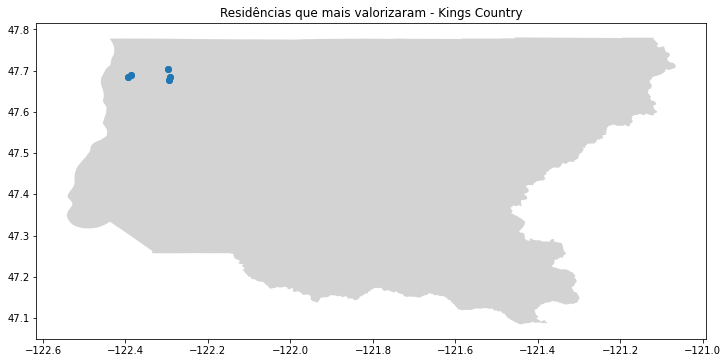

In [44]:
# plotar a localização das residências mais valorizadas
fig, ax = plt.subplots(figsize=(12, 10))
kc_map.plot(ax=ax, color='lightgrey')
geo_df.plot(ax=ax)
ax.set_title('Residências que mais valorizaram - Kings Country')
plt.show()

## 5.5 - Podemos perceber que as residências que mais valorizaram se encontram próximas umas das outras, na cidade de Seattle. Com isso, vamos procurar outras residências nas proximidades com atributos parecidos, para a nossa recomendação

In [86]:
# voltar quantidade máxima de colunas para o padrão
pd.reset_option('max_columns')

# 6.0 - RECOMENDAÇÃO
### Para chegar na conclusão final de recomendação de compra de 5 casas, analisando principalmente as colunas de, preço, quartos, banheiros, area de construção, área do terreno, ano de construção, ano de reforma, qualidade do material de construção, localização, usei a seguinte a lógica:

- Encontrar as 5 casas mais valorizadas entre duas datas diferentes de venda;
- Certificar de que essas 5 casas são próximas umas das outras, para entender se é uma região onde as pessoas gostariam de morar;
- Encontrar as casas com atributos similares as das colunas citadas acima, mas com preço inferior para recomendação de investimento.

## 6.1 Recomendação de investimento
### Com isso entendo que essas 5 casas abaixo tem potencial de valorização


In [70]:
# casas recomendadas
df.loc[(df['city'] == 'Seattle') & (df['grade'] >= 7) & (df['sqft_living'] >= 1400)].sort_values(by='price').head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,city,population,price_sqft,age,age_renovated
2183,4058802105,2014-09-04,150000,3,1,1450,6776,1,0,0,...,98178,47.5056,-122.244,1680,7200,Seattle,24092,22.136954,62,0.0
5725,8864000250,2014-08-27,150550,4,1,1470,6061,1,0,0,...,98168,47.4819,-122.289,1230,6175,Seattle,33734,24.839135,69,0.0
3032,7888100090,2014-09-25,160000,4,1,1520,7298,1,0,0,...,98198,47.3706,-122.310,1520,7298,Seattle,34584,21.923815,54,0.0
13183,1523049207,2014-08-05,161000,4,2,1700,8043,1,0,0,...,98168,47.4758,-122.288,1540,13260,Seattle,33734,20.017406,60,0.0
9876,1219000473,2014-06-26,164950,3,1,1570,15330,1,0,0,...,98166,47.4608,-122.340,1250,13330,Seattle,20301,10.759948,58,0.0


## 6.2 Recomendação de não investimento
### Não recomendo um investimento em casas com valores altos logo de início, pois devido ao alto valor, a venda é mais difícil, e pode levar mais tempo até acontecer, gerando mais despesas para a imobiliária. 


In [87]:
# casas não recomendadas
df.sort_values(by='price', ascending=False).head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,zipcode,lat,long,sqft_living15,sqft_lot15,city,population,price_sqft,age,age_renovated
7252,6762700020,2014-10-13,7700000,6,8,12050,27600,2,0,3,...,98102,47.6298,-122.323,3940,8800,Seattle,20756,278.985507,104,27.0
3914,9808700762,2014-06-11,7062500,5,4,10040,37325,2,1,2,...,98004,47.6500,-122.214,3930,25449,Bellevue,27946,189.216343,74,13.0
9254,9208900037,2014-09-19,6885000,6,7,9890,31374,2,0,4,...,98039,47.6305,-122.240,4540,42730,Medina,2971,219.449225,13,0.0
4411,2470100110,2014-08-04,5570000,5,5,9200,35069,2,0,0,...,98039,47.6289,-122.233,3560,24345,Medina,2971,158.829736,13,0.0
1448,8907500070,2015-04-13,5350000,5,5,8000,23985,2,0,4,...,98004,47.6232,-122.220,4600,21750,Bellevue,27946,223.056077,6,0.0
